## Site mean paleomagnetic directions for complex tectonic restorations

**Calculates mean paleomagnetic directions and plots results in a stereonet in geographic and stratigraphic coordinates.**

**Applies multiple restoration steps for multiphase tectonic deformation (regional tilts, plunging fold axis,...)**

**Runs a test for Inclination error**

*Input data in an excel file with following headers:*

|header      |Description                                             | 
|:-----------|:-------------------------------------------------------|
|sample      |Sample code (name)                                      |
|Dg          |declination in geographic coordinates                   |
|Ig          |Inclination in geographic coordinates                   |
|So_dipdir   |Bedding dip direction                                   |
|So_dip      |Bedding dip                                             |
|Q           |Quality rank ChRM -->[1,2,3] Secondary components --> 4 |

The order and number of columns is not predetermined.

#### Importing modules and function definitions

In [1]:
import pmagpy.pmag as pmag
import pmagpy.pmagplotlib as pmagplotlib
import pmagpy.ipmag as ipmag
import matplotlib.pyplot as plt # our plotting buddy
from pmagpy import convert_2_magic as convert
import numpy as np # the fabulous NumPy package
import pandas as pd # and of course Pandas
has_basemap, Basemap = pmag.import_basemap()
has_cartopy, Cartopy = pmag.import_cartopy()
from IPython.display import Image
%matplotlib inline 

In [2]:
#define a fisher_means function
def fisher_means(di_block,n, tc: bool, foldaxis_plunge = bool):
    mode_1,mode_2=pmag.separate_directions(di_block) #mode_1,mode_2: 2 arrays of nested dec,inc pairs
    # Calculates the Fisher mean and associated parameters
    mode_1_fpars=ipmag.fisher_mean(di_block=mode_1)
    mode_2_fpars=ipmag.fisher_mean(di_block=mode_2)
    mode_N_fpars = dict()
    mode_R_fpars = dict()

    # assign N and R polarity to mode 1 and mode 2
    if 'dec' in mode_1_fpars:
        if mode_1_fpars['dec'] >90 and mode_1_fpars['dec'] <270:
            mode_R_fpars = mode_1_fpars
            mode_R = mode_1
        else:
            mode_N_fpars = mode_1_fpars
            mode_N =mode_1
    if 'dec' in mode_2_fpars:
        if mode_2_fpars['dec'] >90 and mode_2_fpars['dec'] <270:
            mode_R_fpars = mode_2_fpars
            mode_R = mode_2
        else:
            mode_N_fpars = mode_2_fpars
            mode_N =mode_2
    
    # Build a dataframe with fisher statistics of all modes and the overall mean
    mean_mode_N = pd.DataFrame()
    mean_mode_R = pd.DataFrame()

    if 'dec' in mode_N_fpars:
        mean_mode_N = pd.DataFrame(mode_N_fpars, index =['Normal'])
    if 'dec' in mode_R_fpars:
        mean_mode_R = pd.DataFrame(mode_R_fpars, index =['Reverse'])
    all_means = pd.concat([mean_mode_N, mean_mode_R])
 
    # Calculates the Fisher mean of all_to_single_mode directions.
    if mode_R.any():
        to_single_mode_R_dec = mode_R.transpose()[0]+180 # all_to_single mode: all directions shifted to one polarity
        to_single_mode_R_inc = - mode_R.transpose()[1]
        to_single_mode_R = np.array([to_single_mode_R_dec,to_single_mode_R_inc]).transpose()
        if 'mode_N' in locals():
            all_to_single = np.concatenate((mode_N,to_single_mode_R))
        else:
            all_to_single = to_single_mode_R
        all_to_single_fpars =ipmag.fisher_mean(di_block=all_to_single)
        mean_all_to_single = pd.DataFrame(all_to_single_fpars, index =["all to normal"])
        all_means = pd.concat([all_means, mean_all_to_single])

    # arrange columns in dataframe
    cols = all_means.columns.tolist()
    cols = cols[2:3] + cols[:2] + cols[3:]
    all_means = all_means[cols]
    if tc == False:
        all_means = all_means.rename(columns = {cols[1]:'Dg', cols[2]:'Ig'})
        text = 'Geographic coordinates'
        if foldaxis_plunge == True:
            all_means = all_means.rename(columns = {'Dg':'D_foldaxis_untilt', 'Ig':'I_foldaxis_untilt'})
            text = 'Fold axis untilted'
    else:
        all_means = all_means.rename(columns = {cols[1]:'Ds', cols[2]:'Is'})
        text = 'Stratigraphic coordinates'
        if foldaxis_plunge == True:
            all_means = all_means.rename(columns = {'Ds':'D_beds_unfolded', 'Is':'I_beds_unfolded'})
            text = 'Fold axis untilted, beds unfolded'
    all_means = all_means.round(2)
     
    # plot the data
    ipmag.plot_net(n)
    ipmag.plot_di(di_block=di_block,color='black',edge='white',markersize=30)

    # draw on the means and alpha95
    if mode_N_fpars == {}:
        pass
    else:
        ipmag.plot_di_mean(dec=mode_N_fpars['dec'],inc=mode_N_fpars['inc'],a95=mode_N_fpars['alpha95'],\
                  marker='*',color='blue',markersize=50)
    if mode_R_fpars == {}:
        pass
    else:
        ipmag.plot_di_mean(dec=mode_R_fpars['dec'],inc=mode_R_fpars['inc'],a95=mode_R_fpars['alpha95'],\
                  marker='*',color='blue',markersize=50)
        ipmag.plot_di_mean(dec=all_to_single_fpars['dec'],inc=all_to_single_fpars['inc'],a95=all_to_single_fpars['alpha95'],\
                  marker='*',color='green',markersize=50)
    plt.title(site_name)
    plt.text(1,1, text)

    return all_means

### Reading input excel file

In [3]:
### Reading input excel file

#set path to data file. excel file with column headings as "site", "Dg", "Ig", "Ds", "Is"
#path not required if notebook located in the same folder"
path = 'Aguilar/'          #Give a path to folder from working directory. Ex: home/.../workdir/
site_name = "Aguilar"          #Give a site name
file = path+'AG_dir.xlsx'   #Name of input file (excel format as above)

#reading input data file
xls = pd.ExcelFile(file)
datafile = xls.parse(0) #first sheet (0) of the excel file parsed to variable
datafile = datafile.set_index('sample')

In [4]:
datafile.round()

,level (m),So_dipdir,So_dip,Dg,Ig,dec_tc,inc_tc,VGP_lat,E-6A/m,error,Q,temp,range
sample,,,,,,,,,,,,,
AG128-2A,1068.0,240,35,229.0,-65.0,445.0,-79.0,-37.0,142.0,7.0,2,9,350-470
AG127-1A,1062.0,240,35,358.0,38.0,326.0,45.0,58.0,383.0,4.0,1,9,350-510
AG126-2A,1057.0,240,35,352.0,71.0,274.0,58.0,27.0,79.0,8.0,2,9,350-470
AG125-1B,1046.0,240,35,341.0,43.0,308.0,40.0,43.0,68.0,5.0,2,9,350-510
AG124-1A,1042.0,240,35,328.0,-33.0,349.0,-27.0,32.0,53.0,30.0,2,9,350-550
...,...,...,...,...,...,...,...,...,...,...,...,...,...
AG005-1B,90.0,234,27,332.0,69.0,277.0,59.0,30.0,61.0,12.0,3,9,350-520
AG004-1A,78.0,234,27,313.0,65.0,295.0,60.0,42.0,88.0,8.0,2,9,400-520
AG003-1B,68.0,225,28,30.0,44.0,373.0,70.0,76.0,126.0,14.0,3,9,250-300


### Calculate Ds and Is from bedding orientation

In [5]:
# Calculate Ds Is from bedding and Dg Ig
di_g =np.array([datafile["Dg"], datafile["Ig"]]).transpose()
bedding =np.array([datafile["So_dipdir"], datafile["So_dip"]]).transpose()
di_bedding = np.column_stack((di_g,bedding))
Ds, Is = pmag.dotilt_V(di_bedding)
datafile['Ds'] = Ds.tolist()
datafile['Is'] = Is.tolist() 

di_s = np.column_stack((Ds, Is))

In [6]:
datafile.round()

,level (m),So_dipdir,So_dip,Dg,Ig,dec_tc,inc_tc,VGP_lat,E-6A/m,error,Q,temp,range,Ds,Is
sample,,,,,,,,,,,,,,,
AG128-2A,1068.0,240,35,229.0,-65.0,445.0,-79.0,-37.0,142.0,7.0,2,9,350-470,85.0,-79.0
AG127-1A,1062.0,240,35,358.0,38.0,326.0,45.0,58.0,383.0,4.0,1,9,350-510,326.0,45.0
AG126-2A,1057.0,240,35,352.0,71.0,274.0,58.0,27.0,79.0,8.0,2,9,350-470,274.0,58.0
AG125-1B,1046.0,240,35,341.0,43.0,308.0,40.0,43.0,68.0,5.0,2,9,350-510,308.0,40.0
AG124-1A,1042.0,240,35,328.0,-33.0,349.0,-27.0,32.0,53.0,30.0,2,9,350-550,349.0,-27.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AG005-1B,90.0,234,27,332.0,69.0,277.0,59.0,30.0,61.0,12.0,3,9,350-520,277.0,59.0
AG004-1A,78.0,234,27,313.0,65.0,295.0,60.0,42.0,88.0,8.0,2,9,400-520,275.0,50.0
AG003-1B,68.0,225,28,30.0,44.0,373.0,70.0,76.0,126.0,14.0,3,9,250-300,13.0,70.0


In [7]:
pmag.dotilt(229,-65,150,35)

(287.5659580182305, -52.06015618967201)

### Structural Data

In [8]:
reg_tilt_dir = np.full((len(di_g)), 210)
reg_tilt_dip = np.full((len(di_g)), 30)
foldaxis_dir = np.full((len(di_g)), 245)              #direction of fold axis
foldaxis_plunge = np.full((len(di_g)), 48)           #plunge of fold axis

### Regional tilt restoration

In [9]:
#under construction


### Plunging axis restoration

In [10]:
#correction for fold axis plunge
foldaxis_dir = np.full((len(di_g)), 0)              #direction of fold axis
foldaxis_plunge = np.full((len(di_g)), 0)           #plunge of fold axis
di_foldaxis = np.column_stack((di_g,foldaxis_dir,foldaxis_plunge))

#correct D and I (di_g) for plunging axis
D_unplunge, I_unplunge = pmag.dotilt_V(di_foldaxis)
datafile['D_unplunge'] = D_unplunge.tolist()
datafile['I_unplunge'] = I_unplunge.tolist()
di_unplunge = np.column_stack((D_unplunge,I_unplunge))

#correct bedding for plunging axis
bedding_pole = np.array([bedding[:,0]+180,90-bedding[:,1]]).transpose()

beddingpole_foldaxis = np.column_stack((bedding_pole,foldaxis_dir,foldaxis_plunge))
bedpole_ddir_unplunge, bedpole_dip_unplungle = pmag.dotilt_V(beddingpole_foldaxis)
beddingpole_unplunge = np.column_stack((bedpole_ddir_unplunge, bedpole_dip_unplungle))
bedding_unplunge = np.array([beddingpole_unplunge[:,0]-180,90-beddingpole_unplunge[:,1]]).transpose()
#untilt bedding
di_unplunge_bedding = np.column_stack((di_unplunge,bedding_unplunge))
Ds_unplunge, Is_unplunge = pmag.dotilt_V(di_unplunge_bedding)
datafile['Ds_unplunge'] = Ds_unplunge.tolist()
datafile['Is_unplunge'] = Is_unplunge.tolist()
#di_s_unplng = np.column_stack((Ds_unplunge, Is_unplunge))

In [11]:
## Quality of the dataset
N =len(datafile)-len(datafile[datafile["Q"]==4])
Q = [1,2,3,4]
n = [len(datafile[datafile["Q"]==1]),len(datafile[datafile["Q"]==2]),len(datafile[datafile["Q"]==3]),len(datafile[datafile["Q"]==4])]
p = [100*n[0]/N,100*n[1]/N,100*n[2]/N,'']                                                                                                   
quality = {"Quality": Q, "number": n, "percentage": p}
quality_df = pd.DataFrame.from_dict(quality)
quality_df = quality_df.set_index('Quality')
quality_df #show only Q 1 to 3 (ChRM directions. Quality 4 corresponds to secondary components

,number,percentage
Quality,,
1,27,21.259843
2,76,59.84252
3,24,18.897638
4,0,


### Select the Quality rank for the analysis

In [12]:
Qmin = str(input('Set Lower Quality (default¨Q = 2): '))
if not Qmin:
    Qmin = 2
Qmax = str(input('Set HIgher Quality (default Q¨= 1): '))
if not Qmax:
    Qmax = 1
print ('Directions of Quality from '+str(Qmin)+' to '+str(Qmax)+ ' selected')
Qmin = int(Qmin)
Qmax = int(Qmax)
Selecteddata = datafile[datafile['Q'].between(Qmax, Qmin, inclusive=True)]

if 'Ds' in Selecteddata.columns:
    di_s =np.array([Selecteddata["Ds"], Selecteddata["Is"]]).transpose()
if 'Dg' in Selecteddata.columns:
    di_g =np.array([Selecteddata["Dg"], Selecteddata["Ig"]]).transpose()


Set Lower Quality (default¨Q = 2): 
Set HIgher Quality (default Q¨= 1): 
Directions of Quality from 2 to 1 selected


In [13]:
Selecteddata.round()

,level (m),So_dipdir,So_dip,Dg,Ig,dec_tc,inc_tc,VGP_lat,E-6A/m,error,Q,temp,range,Ds,Is,D_unplunge,I_unplunge,Ds_unplunge,Is_unplunge
sample,,,,,,,,,,,,,,,,,,,
AG128-2A,1068.0,240,35,229.0,-65.0,445.0,-79.0,-37.0,142.0,7.0,2,9,350-470,85.0,-79.0,229.0,-65.0,85.0,-79.0
AG127-1A,1062.0,240,35,358.0,38.0,326.0,45.0,58.0,383.0,4.0,1,9,350-510,326.0,45.0,358.0,38.0,326.0,45.0
AG126-2A,1057.0,240,35,352.0,71.0,274.0,58.0,27.0,79.0,8.0,2,9,350-470,274.0,58.0,352.0,71.0,274.0,58.0
AG125-1B,1046.0,240,35,341.0,43.0,308.0,40.0,43.0,68.0,5.0,2,9,350-510,308.0,40.0,341.0,43.0,308.0,40.0
AG124-1A,1042.0,240,35,328.0,-33.0,349.0,-27.0,32.0,53.0,30.0,2,9,350-550,349.0,-27.0,328.0,-33.0,349.0,-27.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AG008-1A,159.0,234,27,31.0,15.0,385.0,40.0,61.0,73.0,12.0,2,9,350-520,25.0,40.0,31.0,15.0,25.0,40.0
AG006-2A,101.0,234,27,344.0,-59.0,372.0,-43.0,22.0,808.0,4.0,1,9,350-520,12.0,-43.0,344.0,-59.0,12.0,-43.0
AG004-1A,78.0,234,27,313.0,65.0,295.0,60.0,42.0,88.0,8.0,2,9,400-520,275.0,50.0,313.0,65.0,275.0,50.0


### Mean directions geographic and (simple) tectonic correction

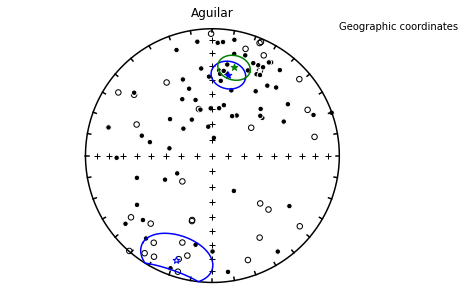

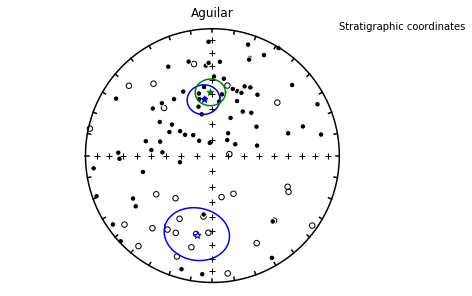

,n,Dg,Ig,r,k,alpha95,csd,n,Ds,Is,r,k,alpha95,csd
Normal,70,11.2,35.3,52.4,3.9,9.9,40.9,70,351.0,53.0,52.2,3.9,10.0,41.1
Reverse,33,199.2,-13.9,21.3,2.7,18.9,48.9,33,191.2,-36.2,21.4,2.8,18.8,48.8
all to normal,103,13.8,29.2,72.6,3.4,9.1,44.2,103,358.2,48.6,72.5,3.3,9.1,44.3


In [14]:
coord_sys =  "bed_correction"

if 'di_g' in globals():
    means_g = fisher_means(di_g,1, tc = False, foldaxis_plunge = False)
    # saving plot to file
    plt.savefig(path+site_name+'_stereplot_notc.pdf', dpi=None, facecolor='w', edgecolor='w', orientation='portrait', papertype=None, format='pdf',
        transparent=False, bbox_inches=None, pad_inches=0.1, frameon=None, metadata=None)
if 'di_s' in globals():
    means_s = fisher_means(di_s,2, tc = True, foldaxis_plunge = False)
    # saving plot to file
    plt.savefig(path+site_name+'_stereplot_tc.pdf', dpi=None, facecolor='w', edgecolor='w', orientation='portrait', papertype=None, format='pdf',
        transparent=False, bbox_inches=None, pad_inches=0.1, frameon=None, metadata=None)

plt.show()
if 'di_g' in globals():
    if 'di_s' in globals():
        means = pd.concat([means_g,means_s], axis =1).round(1)
    else:
        means = means_g
else:
    means = means_s
means

### Mean directions after fold axis unplunged

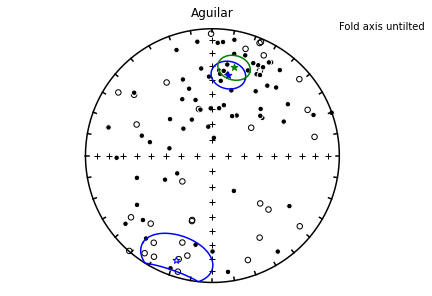

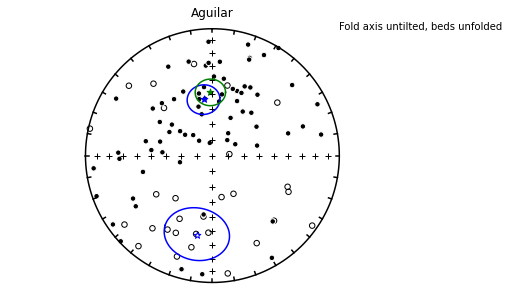

,n,D_foldaxis_untilt,I_foldaxis_untilt,r,k,alpha95,csd,n,D_beds_unfolded,I_beds_unfolded,r,k,alpha95,csd
Normal,70,11.2,35.3,52.4,3.9,9.9,40.9,70,351.0,53.0,52.2,3.9,10.0,41.1
Reverse,33,199.2,-13.9,21.3,2.7,18.9,48.9,33,191.2,-36.2,21.4,2.8,18.8,48.8
all to normal,103,13.8,29.2,72.6,3.4,9.1,44.2,103,358.2,48.6,72.5,3.3,9.1,44.3


In [15]:
coord_sys =  "foldaxis_unplunged"
if 'D_unplunge' in Selecteddata.columns:
    di_unplunge =np.array([Selecteddata["D_unplunge"], Selecteddata["I_unplunge"]]).transpose()
if 'Ds_unplunge' in Selecteddata.columns:
    di_s_unplng =np.array([Selecteddata["Ds_unplunge"], Selecteddata["Is_unplunge"]]).transpose()

means_g_unplng = fisher_means(di_unplunge,1, tc = False, foldaxis_plunge = True)
# saving plot to file
plt.savefig(path+site_name+'_stereplot_foldaxis_corr.pdf', dpi=None, facecolor='w', edgecolor='w', orientation='portrait', papertype=None, format='pdf',
        transparent=False, bbox_inches=None, pad_inches=0.1, frameon=None, metadata=None)

means_s__unplng = fisher_means(di_s_unplng,2, tc = True, foldaxis_plunge = True)
# saving plot to file
plt.savefig(path+site_name+'_stereplot_foldaxis_corr_tc.pdf', dpi=None, facecolor='w', edgecolor='w', orientation='portrait', papertype=None, format='pdf',
        transparent=False, bbox_inches=None, pad_inches=0.1, frameon=None, metadata=None)
plt.show()
means = pd.concat([means_g_unplng,means_s__unplng], axis =1).round(1)
means

### Inclination error test

In [16]:
#test for inclination error
inc_error_test = ''
while inc_error_test != "y" and inc_error_test != "n":
    print('RUN inclination error test?')
    inc_error_test = str(input("(y/n)?:"))
    if inc_error_test == 'y':
        # shift all samples to single polarity
        mode_N,mode_R=pmag.separate_directions(di_s) #mode_1,mode_2: 2 arrays of nested dec,inc pairs
        all_to_single = mode_N
        if mode_R.any():
            to_single_mode_R_dec = mode_R.transpose()[0]+180 # all_to_single mode: all directions shifted to one polarity
            to_single_mode_R_inc = - mode_R.transpose()[1]
            to_single_mode_R = np.array([to_single_mode_R_dec,to_single_mode_R_inc]).transpose()
            all_to_single = np.concatenate((mode_N,to_single_mode_R))
        else:
            pass
        #run function
        ipmag.find_ei(all_to_single) # select data to analyse (mode_1, mode_2 or all_to_single)
       
    if inc_error_test == "n":
        pass

RUN inclination error test?
(y/n)?:n



### Save excel file

In [17]:
outputfile = path+site_name+coord_sys+"_means.xlsx"
export_file = ''
while export_file != "y" and export_file != "n":
    print('save and overwrite', path+site_name,"_means.xlsx?")
    export_file = str(input("(y/n)?:"))
    if export_file == 'y':
        means.to_excel(outputfile)
        print("file saved to ", path+site_name,"_means.xlsx")
    if export_file == "n":
        print("file with mean directions NOT saved")

save and overwrite Aguilar/Aguilar _means.xlsx?
(y/n)?:n
file with mean directions NOT saved
